In [1]:
import numpy as np
import pandas as pd
from utils import *
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances

In [2]:
#spectral_data_mpc_mpb = pd.read_csv('../processed_data/mpb_mpc_data.csv')
#del spectral_data_mpc_mpb['Unnamed: 0']

In [3]:
#df_flopp = pd.read_csv('../processed_data/df_flopp.csv')
#df_flopp_e = pd.read_csv('../processed_data/df_flopp_e.csv')

In [40]:
df_spectra_flopp = pd.read_csv('flopp_flopp_e_pivot.csv')
del df_spectra_flopp['Unnamed: 0']

label_table = (
    df_spectra_flopp.
    query('data_source == "flopp"').
    groupby(['polymer']).
    count()['file_name'].
    reset_index().
    reset_index().
    iloc[:,:-1])

label_table_e = (
    df_spectra_flopp.
    query('data_source == "flopp_e"').
    groupby(['polymer']).
    count()['file_name'].
    reset_index().
    reset_index().
    iloc[:,:-1])

label_table = label_table.merge(label_table_e, on='polymer', how='left')
label_table = label_table.drop(np.where(label_table['polymer'] == 'Polyethylene Adipate')[0][0], axis=0)

del label_table['index_x']
del label_table['index_y']
label_table = label_table.reset_index()
label_table.columns = ['label', 'polymer']
polymer_10_more = ['Cotton', 'Polyethylene', 'Polyethylene Terephthalate','Polypropylene', 'Polystyrene']
label_table = label_table.reset_index(drop=True)

label_table_adaptive = label_table.query('polymer in @polymer_10_more')

label_table['label'] = np.arange(label_table.shape[0])
label_table_adaptive['label'] = np.arange(label_table_adaptive.shape[0])

wl_list = np.float64(df_spectra_flopp.columns[3:-1])

df_spectra_flopp_adaptive = df_spectra_flopp.merge(label_table_adaptive)
df_spectra_flopp = df_spectra_flopp.merge(label_table)

y_train = df_spectra_flopp.query('data_source == "flopp"').iloc[:,1].to_numpy()
label_train = df_spectra_flopp.query('data_source == "flopp"').iloc[:,-1].to_numpy()
X_train = df_spectra_flopp.query('data_source == "flopp"').iloc[:,3:-1].to_numpy()
X_train = (X_train - X_train.mean(1)[:, None]) / X_train.std(1)[:, None]

y_test = df_spectra_flopp.query('data_source == "flopp_e"').iloc[:,1].to_numpy()
label_test = df_spectra_flopp.query('data_source == "flopp_e"').iloc[:,-1].to_numpy()
X_test = df_spectra_flopp.query('data_source == "flopp_e"').iloc[:,3:-1].to_numpy()
X_test = (X_test - X_test.mean(1)[:, None]) / X_test.std(1)[:, None]


y_train_a = df_spectra_flopp_adaptive.query('data_source == "flopp"').iloc[:,1].to_numpy()
label_train_a = df_spectra_flopp_adaptive.query('data_source == "flopp"').iloc[:,-1].to_numpy()
X_train_a = df_spectra_flopp_adaptive.query('data_source == "flopp"').iloc[:,3:-1].to_numpy()
X_train_a = (X_train_a - X_train_a.mean(1)[:, None]) / X_train_a.std(1)[:, None]

y_test_a = df_spectra_flopp_adaptive.query('data_source == "flopp_e"').iloc[:,1].to_numpy()
label_test_a = df_spectra_flopp_adaptive.query('data_source == "flopp_e"').iloc[:,-1].to_numpy()
X_test_a = df_spectra_flopp_adaptive.query('data_source == "flopp_e"').iloc[:,3:-1].to_numpy()
X_test_a = (X_test_a - X_test_a.mean(1)[:, None]) / X_test_a.std(1)[:, None]


/var/folders/9g/bj6gc6z17_1fyb7lx57xf04m0000gs/T/ipykernel_4765/205216376.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_table_adaptive['label'] = np.arange(label_table_adaptive.shape[0])


In [43]:
with open('data.npy', 'wb') as f:
    np.save(f, X_train)
    np.save(f, y_train)
    np.save(f, label_train)
    
    np.save(f, X_train_a)
    np.save(f, y_train_a)
    np.save(f, label_train_a)
    
    np.save(f, X_test)
    np.save(f, y_test)
    np.save(f, label_test)
    
    np.save(f, X_test_a)
    np.save(f, y_test_a)
    np.save(f, label_test_a)

In [2]:
with open('data.npy', 'rb') as f:
    X_train = np.load(f, allow_pickle=True)
    y_train = np.load(f, allow_pickle=True)
    label_train = np.load(f, allow_pickle=True)
    
    X_train_a = np.load(f, allow_pickle=True)
    y_train_a = np.load(f, allow_pickle=True)
    label_train_a = np.load(f, allow_pickle=True)
    
    X_test = np.load(f, allow_pickle=True)
    y_test = np.load(f, allow_pickle=True)
    label_test = np.load(f, allow_pickle=True)
    
    X_test_a = np.load(f, allow_pickle=True)
    y_test_a = np.load(f, allow_pickle=True)
    label_test_a = np.load(f, allow_pickle=True)
    

In [6]:
np.unique(y_test).shape

(11,)

In [7]:
(df_spectra_flopp.
 groupby(['data_source', 'polymer']).
 count().
 reset_index().
 iloc[:,:3].
 pivot(index='polymer', values='file_name', columns='data_source').reset_index())

data_source,polymer,flopp,flopp_e
0,Acrylic,6.0,NaN
1,Acrylonitrile Butadiene Styrene,14.0,1.0
2,Cotton,14.0,12.0
3,Polyamide,12.0,6.0
4,Polycarbonate,8.0,1.0
5,Polyethylene,18.0,49.0
6,Polyethylene Terephthalate,25.0,22.0
7,Polyethylene Vinyl Acetate,10.0,5.0
8,Polylactic acid,8.0,NaN
9,Polypropylene,19.0,66.0


In [8]:
(df_spectra_flopp_adaptive.
 groupby(['data_source', 'polymer']).
 count().
 reset_index().
 iloc[:,:3].
 pivot(index='polymer', values='file_name', columns='data_source').reset_index())

data_source,polymer,flopp,flopp_e
0,Cotton,14,12
1,Polyethylene,18,49
2,Polyethylene Terephthalate,25,22
3,Polypropylene,19,66
4,Polystyrene,14,12


In [9]:
smx = smx_pcc(X_train, X_test, label_train)
(np.argmax(smx, 1) == label_test).mean()
#sns.heatmap(smx)

0.8201058201058201

In [10]:
smx = smx_pcc(X_train_a, X_test_a, label_train_a)
(np.argmax(smx, 1) == label_test_a).mean()
#sns.heatmap(smx)

0.9130434782608695

In [11]:
(np.argmax(smx_pcc(X_train, X_test, label_train), 1) == label_test).mean()

0.8201058201058201

In [12]:
(np.argmax(smx_pcc(X_train, X_test, label_train), 1) == np.argmax(smx_nn(X_train, X_test, label_train), 1)).mean()

1.0

In [13]:
clf = LogisticRegression(random_state=0)#, C=1, penalty='l1', solver='saga')
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

/Users/eochoa/opt/anaconda3/envs/working/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.91005291005291

# Examples KnowItAll vs CP

In [14]:
np.array(df_spectra_flopp.query('data_source == "flopp_e" and polymer == "Polyethylene"')['file_name'])

array(['PE 1. Black Pellet.CSV', 'PE 10. Blue Fragment.CSV',
       'PE 11. Green Fragment.CSV', 'PE 12. White Film.CSV',
       'PE 13. White Fragment.CSV', 'PE 14. Green Fragment.CSV',
       'PE 15. Blue Film.CSV', 'PE 16. White Fragment.CSV',
       'PE 17. Green Fragment.CSV', 'PE 18. White Fragment.CSV',
       'PE 19. Blue Fragment.CSV', 'PE 2. White Pellet.CSV',
       'PE 20. Yellow Fragment.CSV', 'PE 21. Pink Fragment.CSV',
       'PE 22. Red Film.CSV', 'PE 23. Purple Film.CSV',
       'PE 24. Clear Film.CSV', 'PE 25. Orange Foam.CSV',
       'PE 26. Blue Foam.CSV', 'PE 27. White Fragment.CSV',
       'PE 28. White Film.CSV', 'PE 29. Yellow Fragment.CSV',
       'PE 3. Clear Pellet.CSV', 'PE 30. Black Fragment.CSV',
       'PE 31. Orange Fragment.CSV', 'PE 32. Red Fragment.CSV',
       'PE 33. Brown Fragment.CSV', 'PE 34. Black Fragment.CSV',
       'PE 35. Black Fragment.CSV', 'PE 36. Red Fragment.CSV',
       'PE 37. Yellow Fragment.CSV', 'PE 38. Grey Fragment.CSV',
       

In [13]:
np.array(df_spectra_flopp.query('data_source == "flopp_e" and polymer == "Polypropylene"')['file_name'])

array(['PP 1. White Fragment.CSV', 'PP 10. Yellow Fragment.CSV',
       'PP 11. Yellow Straw Fragment.CSV', 'PP 12. White Fragment.CSV',
       'PP 13. Grey Fragment.CSV', 'PP 14. Orange Fragment.CSV',
       'PP 15. Pink Fragment.CSV', 'PP 16. Yellow Fragment.CSV',
       'PP 17. Red Fragment.CSV', 'PP 18. Grey Fragment.CSV',
       'PP 19. White Fiber.CSV', 'PP 2. Purple Fragment.CSV',
       'PP 20. White Film.CSV', 'PP 21. Grey Fragment.CSV',
       'PP 22. Red Fragment.CSV', 'PP 23. Yellow Fragment.CSV',
       'PP 24. Clear Fragment.CSV', 'PP 25. Orange Fragment.CSV',
       'PP 26. Yellow Fiber.CSV', 'PP 27. Blue Fragment.CSV',
       'PP 28. Red Fragment.CSV', 'PP 29. Green Fragment.CSV',
       'PP 3. Yellow Fragment.CSV', 'PP 30. Clear Fragment.CSV',
       'PP 31. Purple Fragment.CSV', 'PP 32. Blue Film.CSV',
       'PP 33. Clear Film.CSV', 'PP 34. Brown Film.CSV',
       'PP 35. Clear Film.CSV', 'PP 36. Purple Film.CSV',
       'PP 37. White Fragment.CSV', 'PP 38. Blue Frag

In [15]:
PE_ex = [
         'PE 33. Brown Fragment.CSV', 
         'PE 30. Black Fragment.CSV', 
         'PE 15. Blue Film.CSV', 
         'PE 40. Clear Fragment.CSV', 
         'PE 34. Black Fragment.CSV'
        ]


In [16]:
PP_ex = [
            'PP 12. White Fragment.CSV',
            'PP 28. Red Fragment.CSV',
            'PP 48. Brown Fragment.CSV',
            'PP 54. Red Fragment.CSV',
        ]

In [17]:
df_spectra_flopp.query('file_name in @PE_ex')

,file_name,polymer,data_source,674.9918,676.9203,678.8489,680.7775,682.706,684.6345,686.5631,...,3984.38,3986.309,3988.237,3990.166,3992.094,3994.023,3995.951,3997.88,3999.809,label
99,PE 15. Blue Film.CSV,Polyethylene,flopp_e,-1.053001,-1.015244,-0.964920,-1.009025,-1.044532,-1.032505,-1.026680,...,0.656945,0.660431,0.659207,0.659770,0.669193,0.670829,0.661770,0.663345,0.671314,5
123,PE 30. Black Fragment.CSV,Polyethylene,flopp_e,-1.463378,-1.476736,-1.474131,-1.451425,-1.450110,-1.504805,-1.524429,...,0.773248,0.783526,0.795709,0.799757,0.799166,0.797552,0.790095,0.788483,0.790298,5
130,PE 33. Brown Fragment.CSV,Polyethylene,flopp_e,-1.779408,-1.740449,-1.713181,-1.714105,-1.668331,-1.635757,-1.650872,...,0.819784,0.827527,0.841371,0.835817,0.828024,0.839945,0.831043,0.823234,0.826415,5
131,PE 34. Black Fragment.CSV,Polyethylene,flopp_e,-1.598203,-1.572007,-1.575330,-1.602245,-1.588286,-1.575046,-1.612052,...,0.838762,0.836594,0.842354,0.850096,0.849767,0.846051,0.840374,0.835624,0.835403,5
139,PE 40. Clear Fragment.CSV,Polyethylene,flopp_e,-1.517614,-1.520021,-1.510719,-1.483527,-1.464128,-1.438478,-1.443173,...,0.745029,0.746495,0.747287,0.745108,0.743190,0.749023,0.747912,0.745232,0.750546,5


In [18]:
smx = smx_pcc(X_train, X_test, label_train)    
idx = np.array([name not in PP_ex for name in np.array(df_spectra_flopp.query('data_source == "flopp_e"')['file_name'])])
cal_smx, val_smx = smx[idx,:], smx[~idx,:]
cal_labels, val_labels = label_test[idx], label_test[~idx]
n = cal_smx.shape[0]

In [19]:
(prediction_sets, empirical_coverage), qhat = conform_pref(cal_smx, val_smx, cal_labels, n, .1, val_labels, cond=0)
prediction_sets.sum(1), empirical_coverage, 1-qhat, prediction_sets[:,4]

(array([3, 3, 1, 1]),
 1.0,
 0.8364288789942408,
 array([False, False, False, False]))

# Distributions HQI

In [32]:
dict_polymers = pd.read_csv('dict_polymers.csv')
del dict_polymers['Unnamed: 0']#.iloc[:,1:]
dict_polymers = dict_polymers.drop([4, 6], axis=0)

In [33]:
smx = smx_pcc(X_train, X_test, label_train)
pe_df = pd.DataFrame(smx[y_test == "Polypropylene", :]) # Polyethylene, Polypropylene
pe_df.columns = label_table.merge(dict_polymers, how='left')['pol_short_names']
pe_df

pol_short_names,Acrylic,ABS,C,PA,PC,PE,PET,PEVA,PLA,PP,PS,PU,PVC,R
0,0.545527,0.502678,0.368984,0.473917,0.325554,0.745954,0.506490,0.795397,0.345189,0.991143,0.447519,0.473572,0.550159,0.865820
1,0.515818,0.573085,0.440119,0.582392,0.275362,0.784461,0.564158,0.825085,0.328344,0.982647,0.532306,0.532997,0.550185,0.892589
2,0.694081,0.693493,0.576717,0.620405,0.460198,0.758955,0.686078,0.858639,0.498834,0.947645,0.626800,0.680124,0.732089,0.932313
3,0.697179,0.731540,0.680513,0.659908,0.440783,0.800952,0.688696,0.855231,0.520476,0.913773,0.671570,0.743728,0.763139,0.915960
4,0.484113,0.508000,0.350692,0.523986,0.234421,0.771043,0.497833,0.795402,0.270122,0.990208,0.456745,0.445725,0.485090,0.861171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,0.462666,0.430147,0.317634,0.517640,0.174264,0.721961,0.445450,0.748434,0.220683,0.962356,0.429400,0.402552,0.410412,0.791173
62,0.454909,0.402515,0.261295,0.396840,0.206647,0.747537,0.400616,0.759319,0.228332,0.983399,0.361046,0.369397,0.421631,0.804467
63,0.530452,0.602786,0.415703,0.534715,0.272459,0.768286,0.540948,0.772468,0.279903,0.985276,0.545544,0.496944,0.561037,0.889299
64,0.461681,0.551836,0.394984,0.536184,0.243329,0.905553,0.485213,0.892085,0.278087,0.978255,0.491435,0.461873,0.517976,0.903567


In [23]:
pe_df.to_csv('Distri_matches_PP.csv')

In [29]:
smx = smx_pcc(X_train, X_test, label_train)
pe_df = pd.DataFrame(smx[y_test == "Polyethylene", :]) # Polyethylene, Polypropylene
pe_df.columns = label_table.merge(dict_polymers, how='left')['pol_short_names']
pe_df

pol_short_names,Acrylic,ABS,C,PA,PC,PE,PET,PEVA,PLA,PP,PS,PU,PVC,R
0,0.382446,0.488005,0.367267,0.556153,0.221408,0.971978,0.431363,0.931160,0.264359,0.858285,0.459409,0.426061,0.458171,0.818976
1,0.667038,0.736345,0.782142,0.632563,0.445184,0.881739,0.644622,0.882990,0.562945,0.757083,0.654713,0.774627,0.795304,0.889355
2,0.584676,0.662135,0.654487,0.610009,0.381853,0.893870,0.596834,0.913363,0.456651,0.828738,0.586296,0.663175,0.697030,0.903197
3,0.442914,0.573749,0.432715,0.595541,0.241745,0.975371,0.492693,0.943081,0.298580,0.888909,0.531728,0.492324,0.513283,0.860059
4,0.487413,0.575743,0.524566,0.586343,0.310016,0.939340,0.499589,0.929668,0.382279,0.843667,0.539364,0.553875,0.583441,0.865992
5,0.154950,0.249132,0.141177,0.398617,-0.043866,0.955976,0.153802,0.800552,-0.007409,0.764932,0.237942,0.188649,0.127310,0.773717
6,0.531332,0.594215,0.648602,0.654568,0.347507,0.840997,0.576328,0.891885,0.485027,0.783654,0.624523,0.674610,0.687519,0.831946
7,0.346111,0.360202,0.409612,0.491682,0.162998,0.917111,0.350200,0.890751,0.250245,0.780428,0.375899,0.414821,0.409772,0.772154
8,0.206877,0.332064,0.154862,0.392284,0.046940,0.991473,0.220287,0.847229,0.052781,0.790389,0.296977,0.205980,0.242106,0.824409
9,0.437043,0.520522,0.539120,0.614647,0.230939,0.882163,0.502021,0.905186,0.346320,0.828201,0.562709,0.531758,0.564632,0.823522


In [217]:
pe_df.to_csv('Distri_matches_PE.csv')

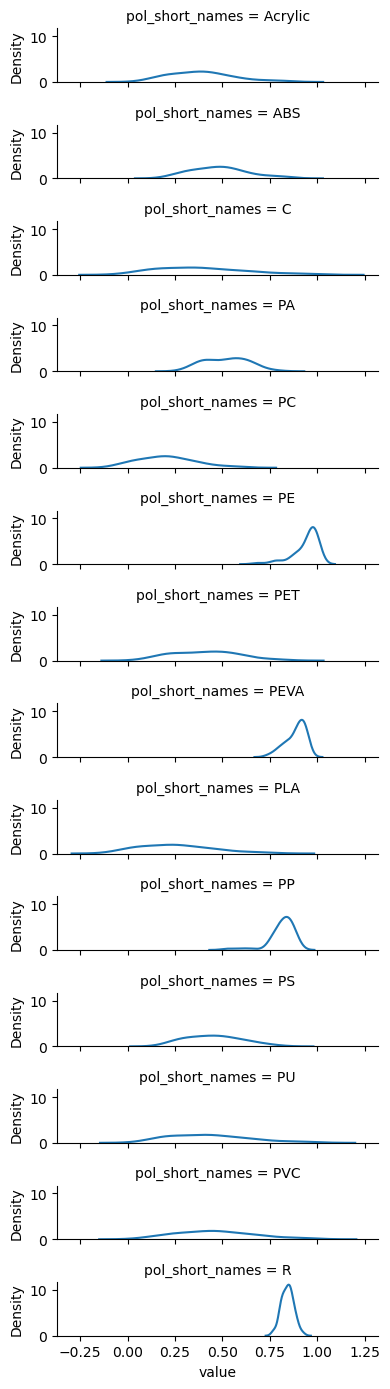

In [35]:
smx = smx_pcc(X_train, X_test, label_train)
pe_df = pd.DataFrame(smx[y_test == "Polyethylene", :]) # Polyethylene, Polypropylene
pe_df.columns = label_table.merge(dict_polymers, how='left')['pol_short_names']
pe_df = pe_df.melt()

ordered_days = pe_df.index
g = sns.FacetGrid(pe_df, row='pol_short_names',
                  height=1, aspect=4)
g.map(sns.kdeplot, 'value')

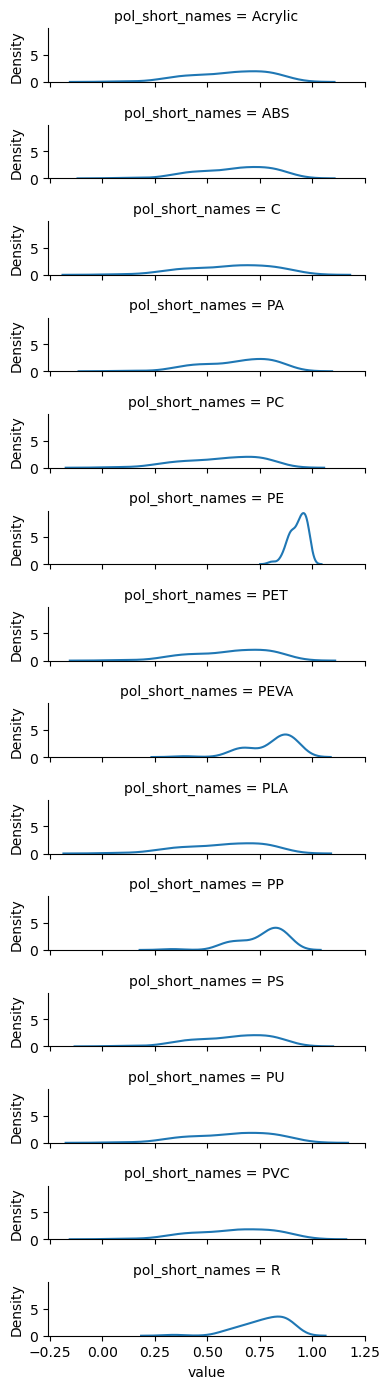

In [27]:
smx = smx_nn(X_train, X_test, label_train)
pe_df = pd.DataFrame(smx[y_test == "Polyethylene", :])
pe_df.columns = label_table.merge(dict_polymers, how='left')['pol_short_names']
pe_df = pe_df.melt()

ordered_days = pe_df.index
g = sns.FacetGrid(pe_df, row='pol_short_names',
                  height=1, aspect=4)
g.map(sns.kdeplot, 'value')

# Traditional CP

## 11 labels

In [36]:
alphas = np.linspace(0.01,0.20, 20)
alphas

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ])

In [37]:
smx = smx_pcc(X_train, X_test, label_train)
res_df_hqi, _ = experiment(smx, label_test, alphas, N=500, adaptive=0, cal_prop=0.9, initial_seed=0)
res_df_hqi

,n_sim,alpha,cov_mean,set_size_mean,cov_sd,set_size_sd,zero_sets,one_sets
0,500,0.01,0.994211,10.930737,0.018675,0.931201,0.000000,0.000000
1,500,0.02,0.988211,9.181474,0.026307,1.277527,0.000000,0.000000
2,500,0.03,0.976421,6.624526,0.037487,0.969067,0.000000,0.000000
3,500,0.04,0.971684,5.665789,0.040923,0.590290,0.000000,0.000526
4,500,0.05,0.961263,5.112737,0.047143,0.651710,0.000000,0.007474
5,500,0.06,0.950632,4.258526,0.053107,0.447858,0.001684,0.027368
6,500,0.07,0.943263,4.010105,0.055897,0.484677,0.004632,0.032632
7,500,0.08,0.932526,3.414632,0.059789,0.416632,0.008211,0.073684
8,500,0.09,0.918842,2.844000,0.065994,0.530903,0.018632,0.177368
9,500,0.10,0.906526,2.237684,0.069303,0.395913,0.034842,0.314842


In [38]:
smx = smx_nn(X_train, X_test, label_train)
res_df_nn, _ = experiment(smx, label_test, alphas, N=500, adaptive=0, cal_prop=0.9, initial_seed=0)
res_df_nn

,n_sim,alpha,cov_mean,set_size_mean,cov_sd,set_size_sd,zero_sets,one_sets
0,500,0.01,0.993789,5.786842,0.019415,1.196499,0.000000,0.376105
1,500,0.02,0.988211,4.793368,0.026307,1.062554,0.000000,0.412842
2,500,0.03,0.977368,3.805263,0.035894,0.913418,0.000000,0.475684
3,500,0.04,0.971263,3.384105,0.040079,0.909910,0.000000,0.522316
4,500,0.05,0.960105,2.413579,0.047527,0.596383,0.000000,0.633789
5,500,0.06,0.948842,2.016316,0.053860,0.431431,0.000000,0.669474
6,500,0.07,0.942842,1.973789,0.056062,0.421033,0.000000,0.677368
7,500,0.08,0.931895,1.829474,0.060733,0.383100,0.000000,0.699053
8,500,0.09,0.920526,1.604421,0.064844,0.293747,0.000000,0.734632
9,500,0.10,0.909263,1.465789,0.069661,0.244607,0.000000,0.770211


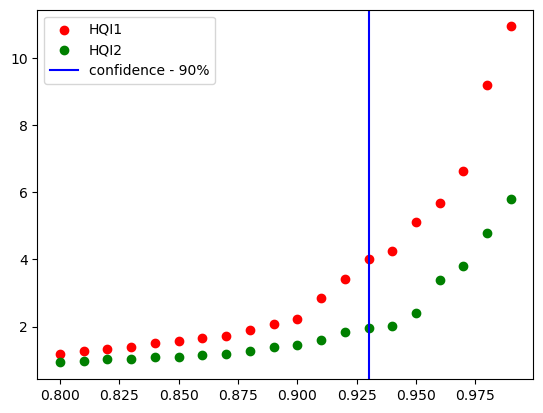

In [237]:
plt.scatter(1-res_df_hqi['alpha'], res_df_hqi['set_size_mean'], c='red', label='HQI1')
plt.scatter(1-res_df_nn['alpha'], res_df_nn['set_size_mean'], c='g', label='HQI2')
plt.axvline(x = 0.93, color = 'b', label = 'confidence - 90%')
plt.legend()

## 5 labels

In [77]:
alphas[9:]

array([0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ])

In [78]:
smx = smx_pcc(X_train_a, X_test_a, label_train_a)
res_df_hqi, tpl = experiment(smx, label_test_a, alphas[9:], N=500, adaptive=0, cal_prop=0.9, initial_seed=0)
res_df_hqi

,n_sim,alpha,cov_mean,set_size_mean,cov_sd,set_size_sd,zero_sets,one_sets
0,500,0.10,0.904000,1.235059,0.073954,0.163271,0.038471,0.688000
1,500,0.11,0.896588,1.171529,0.077581,0.149659,0.046235,0.736000
2,500,0.12,0.882588,1.093765,0.080911,0.130492,0.064824,0.776588
3,500,0.13,0.876706,1.070000,0.084321,0.138128,0.075529,0.778941
4,500,0.14,0.862000,1.005059,0.088398,0.132720,0.097294,0.800353
5,500,0.15,0.854941,0.978471,0.088838,0.127744,0.105059,0.811412
6,500,0.16,0.841882,0.923765,0.093058,0.126277,0.127647,0.820941
7,500,0.17,0.835412,0.897412,0.094287,0.121103,0.139294,0.824000
8,500,0.18,0.823529,0.859647,0.097370,0.111315,0.158000,0.824353
9,500,0.19,0.817882,0.846824,0.099110,0.108452,0.165647,0.821882


In [79]:
cov_by_label_hqi, _, _ = tpl
cov_by_label_list = []
alpha = alphas[9]
for alpha in alphas[9:]:#, cov_by_label_hqi2[0.05]]:
    dfs = cov_by_label_hqi[alpha]
    cov_by_label_table = (pd.concat(dfs).
     groupby('label').
     mean().
     merge(label_table_adaptive, left_index=True, right_on='label'))#.
     #merge(pd.concat(set_size_by_label[0.06076923076923077]).groupby('label').count(), left_on='id', right_on='label'))
    del cov_by_label_table['label']
    cov_by_label_table.columns = ['cov ' + str(round(100*(1-alpha))), 'polymer']
    cov_by_label_table = np.round(cov_by_label_table.set_index('polymer').sort_values('cov ' + str(round(100*(1-alpha)))), 2)
    cov_by_label_list.append(cov_by_label_table)
    
pd.concat(cov_by_label_list, axis=1).sort_index()

,cov 90,cov 89,cov 88,cov 87,cov 86,cov 85,cov 84,cov 83,cov 82,cov 81,cov 80
polymer,,,,,,,,,,,
Cotton,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,96.06
Polyethylene,91.50,91.15,90.67,89.91,88.73,88.40,85.70,83.73,80.24,79.26,78.11
Polyethylene Terephthalate,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
Polypropylene,82.99,81.58,78.74,77.91,76.21,75.13,74.12,74.00,73.62,73.00,71.14
Polystyrene,100.00,100.00,99.74,98.97,93.04,90.96,89.73,89.73,89.73,89.73,89.73


In [86]:
smx = smx_nn(X_train_a, X_test_a, label_train_a)
res_df_nn, tpl = experiment(smx, label_test_a, alphas[9:], N=500, adaptive=0, cal_prop=0.9, initial_seed=0)
res_df_nn

,n_sim,alpha,cov_mean,set_size_mean,cov_sd,set_size_sd,zero_sets,one_sets
0,500,0.10,0.905765,0.980941,0.068690,0.042866,0.021412,0.977412
1,500,0.11,0.898471,0.966471,0.071922,0.047973,0.033529,0.966471
2,500,0.12,0.884824,0.942706,0.076972,0.059447,0.057294,0.942706
3,500,0.13,0.877765,0.930118,0.080567,0.070014,0.069882,0.930118
4,500,0.14,0.865294,0.908118,0.086890,0.080443,0.091882,0.908118
5,500,0.15,0.859882,0.898824,0.087726,0.078780,0.101176,0.898824
6,500,0.16,0.847882,0.886353,0.091934,0.083674,0.113647,0.886353
7,500,0.17,0.841529,0.880000,0.093089,0.086019,0.120000,0.880000
8,500,0.18,0.826824,0.865059,0.095954,0.090128,0.134941,0.865059
9,500,0.19,0.818353,0.856353,0.099205,0.094898,0.143647,0.856353


In [87]:
cov_by_label_hqi, _, _ = tpl
cov_by_label_list = []
alpha = alphas[9]
for alpha in alphas[9:]:#, cov_by_label_hqi2[0.05]]:
    dfs = cov_by_label_hqi[alpha]
    cov_by_label_table = (pd.concat(dfs).
     groupby('label').
     mean().
     merge(label_table_adaptive, left_index=True, right_on='label'))#.
     #merge(pd.concat(set_size_by_label[0.06076923076923077]).groupby('label').count(), left_on='id', right_on='label'))
    del cov_by_label_table['label']
    cov_by_label_table.columns = ['cov ' + str(round(100*(1-alpha))), 'polymer']
    cov_by_label_table = np.round(cov_by_label_table.set_index('polymer').sort_values('cov ' + str(round(100*(1-alpha)))), 2)
    cov_by_label_list.append(cov_by_label_table)
    
pd.concat(cov_by_label_list, axis=1).sort_index()

,cov 90,cov 89,cov 88,cov 87,cov 86,cov 85,cov 84,cov 83,cov 82,cov 81,cov 80
polymer,,,,,,,,,,,
Cotton,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
Polyethylene,92.40,91.36,89.45,88.17,84.88,83.12,79.52,77.65,73.96,72.99,71.76
Polyethylene Terephthalate,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
Polypropylene,84.41,83.36,81.49,80.71,80.15,80.15,80.09,79.93,78.96,77.54,75.30
Polystyrene,89.73,89.73,89.73,89.73,89.73,89.73,89.73,89.73,89.73,89.73,89.73


# Adaptive

In [114]:
smx = smx_pcc(X_train_a, X_test_a, label_train_a)
res_df_hqi, tpl = experiment(smx, label_test_a, alphas[9:], N=1000, adaptive=1, cal_prop=0.9, initial_seed=0)
res_df_hqi

,n_sim,alpha,cov_mean,set_size_mean,cov_sd,set_size_sd,zero_sets,one_sets
0,391,0.10,0.927336,1.349030,0.065874,0.143912,0.054461,0.542049
1,786,0.11,0.918650,1.301602,0.068816,0.155990,0.063164,0.572070
2,950,0.12,0.909536,1.256966,0.073424,0.141319,0.067740,0.607554
3,992,0.13,0.905242,1.244248,0.074327,0.144064,0.071750,0.612251
4,992,0.14,0.894687,1.215370,0.078539,0.142189,0.077740,0.629151
5,999,0.15,0.883648,1.196785,0.082384,0.145735,0.088324,0.626568
6,999,0.16,0.874227,1.174881,0.084571,0.151016,0.095566,0.633987
7,1000,0.17,0.866588,1.145647,0.087372,0.159144,0.105294,0.643765
8,1000,0.18,0.858941,1.116412,0.088775,0.163065,0.114647,0.654294
9,1000,0.19,0.851235,1.076000,0.092545,0.163913,0.124765,0.674471


In [115]:
cov_by_label_hqi, _, _ = tpl
cov_by_label_list = []
alpha = alphas[9]
for alpha in alphas[9:]:#, cov_by_label_hqi2[0.05]]:
    dfs = cov_by_label_hqi[alpha]
    cov_by_label_table = (pd.concat(dfs).
     groupby('label').
     mean().
     merge(label_table_adaptive, left_index=True, right_on='label'))#.
     #merge(pd.concat(set_size_by_label[0.06076923076923077]).groupby('label').count(), left_on='id', right_on='label'))
    del cov_by_label_table['label']
    cov_by_label_table.columns = ['cov ' + str(round(100*(1-alpha))), 'polymer']
    cov_by_label_table = np.round(cov_by_label_table.set_index('polymer').sort_values('cov ' + str(round(100*(1-alpha)))), 2)
    cov_by_label_list.append(cov_by_label_table)
    
pd.concat(cov_by_label_list, axis=1).sort_index()

,cov 90,cov 89,cov 88,cov 87,cov 86,cov 85,cov 84,cov 83,cov 82,cov 81,cov 80
polymer,,,,,,,,,,,
Cotton,91.43,90.48,90.41,90.15,90.15,90.19,90.19,90.18,90.18,90.18,90.18
Polyethylene,92.62,91.95,90.49,90.15,88.51,87.86,86.50,85.92,84.78,84.03,83.02
Polyethylene Terephthalate,95.20,95.27,95.46,95.62,94.85,92.25,91.42,91.17,91.10,89.78,86.93
Polypropylene,92.33,91.13,90.07,89.38,88.19,86.76,85.93,84.71,83.76,82.62,81.35
Polystyrene,89.88,89.93,90.18,90.05,90.05,89.96,89.96,89.97,89.97,89.97,89.97


In [116]:
smx = smx_nn(X_train_a, X_test_a, label_train_a)
res_df_nn, tpl = experiment(smx, label_test_a, alphas[9:], N=1000, adaptive=1, cal_prop=0.9, initial_seed=0)
res_df_nn

,n_sim,alpha,cov_mean,set_size_mean,cov_sd,set_size_sd,zero_sets,one_sets
0,391,0.10,0.927787,1.078080,0.062453,0.111073,0.040921,0.852716
1,786,0.11,0.918800,1.041386,0.066458,0.104823,0.049394,0.866936
2,950,0.12,0.908916,0.996718,0.070363,0.091250,0.057276,0.888916
3,992,0.13,0.904352,0.979127,0.072388,0.088573,0.060306,0.900261
4,992,0.14,0.894153,0.954874,0.076027,0.082075,0.067481,0.910164
5,999,0.15,0.882942,0.934641,0.080864,0.083411,0.080728,0.903904
6,999,0.16,0.873815,0.923217,0.082477,0.082936,0.089030,0.898722
7,1000,0.17,0.865529,0.912529,0.085329,0.083642,0.095824,0.895824
8,1000,0.18,0.859412,0.906176,0.088507,0.084325,0.099647,0.894529
9,1000,0.19,0.851000,0.897765,0.091184,0.084660,0.104824,0.892588


In [117]:
cov_by_label_hqi, _, _ = tpl
cov_by_label_list = []
alpha = alphas[9]
for alpha in alphas[9:]:#, cov_by_label_hqi2[0.05]]:
    dfs = cov_by_label_hqi[alpha]
    cov_by_label_table = (pd.concat(dfs).
     groupby('label').
     mean().
     merge(label_table_adaptive, left_index=True, right_on='label'))#.
     #merge(pd.concat(set_size_by_label[0.06076923076923077]).groupby('label').count(), left_on='id', right_on='label'))
    del cov_by_label_table['label']
    cov_by_label_table.columns = ['cov ' + str(round(100*(1-alpha))), 'polymer']
    cov_by_label_table = np.round(cov_by_label_table.set_index('polymer').sort_values('cov ' + str(round(100*(1-alpha)))), 2)
    cov_by_label_list.append(cov_by_label_table)
    
pd.concat(cov_by_label_list, axis=1).sort_index()

,cov 90,cov 89,cov 88,cov 87,cov 86,cov 85,cov 84,cov 83,cov 82,cov 81,cov 80
polymer,,,,,,,,,,,
Cotton,88.98,90.14,89.71,89.66,89.66,89.57,89.57,89.59,89.59,89.59,89.59
Polyethylene,92.67,91.79,90.69,90.30,88.71,88.10,86.82,86.09,85.27,84.54,83.30
Polyethylene Terephthalate,95.39,95.51,95.60,95.76,93.99,91.32,90.77,90.36,90.27,89.50,86.45
Polypropylene,92.42,91.25,90.01,89.27,88.26,86.78,85.92,84.68,83.84,82.57,81.37
Polystyrene,89.88,89.93,90.27,90.16,90.16,90.04,90.04,90.05,90.05,90.05,90.05


# PE

In [133]:
smx = smx_pcc(X_train, X_test, label_train)
m = label_table['polymer'] == 'Polyethylene'
idx_label = np.where(m)[0][0]
res_df_hqi, _ = experiment(smx, label_test, alphas, N=500, adaptive=0, cal_prop=0.9, initial_seed=0, filter_label=idx_label)
res_df_hqi

,n_sim,alpha,cov_mean,set_size_mean,cov_sd,set_size_sd,zero_sets,one_sets
0,500,0.01,1.000000,8.465516,0.000000,1.802297,0.000000,0.000000
1,500,0.02,1.000000,6.880631,0.000000,1.766441,0.000000,0.000000
2,500,0.03,0.997933,5.170498,0.023994,1.186407,0.000000,0.000000
3,500,0.04,0.993229,4.662789,0.038524,0.879095,0.000000,0.000000
4,500,0.05,0.980276,4.477000,0.063785,0.723251,0.000000,0.000000
5,500,0.06,0.978376,4.329194,0.069678,0.627089,0.000000,0.000000
6,500,0.07,0.972235,4.277166,0.081774,0.624189,0.000000,0.000000
7,500,0.08,0.949704,4.016083,0.105787,0.556786,0.000000,0.002567
8,500,0.09,0.916686,3.610521,0.134932,0.523161,0.000333,0.037123
9,500,0.10,0.910293,2.998210,0.137514,0.566353,0.001900,0.132635


In [134]:
smx = smx_nn(X_train, X_test, label_train)
res_df_nn, _ = experiment(smx, label_test, alphas, N=500, adaptive=0, cal_prop=0.9, initial_seed=0, filter_label=idx_label)
res_df_nn

,n_sim,alpha,cov_mean,set_size_mean,cov_sd,set_size_sd,zero_sets,one_sets
0,500,0.01,0.999333,5.083482,0.014892,2.203284,0.000000,0.298594
1,500,0.02,0.995831,3.981754,0.030835,1.853092,0.000000,0.322668
2,500,0.03,0.978943,3.143723,0.067600,1.457477,0.000000,0.419178
3,500,0.04,0.969737,2.842106,0.090998,1.225250,0.000000,0.454321
4,500,0.05,0.946317,2.079223,0.121745,0.748842,0.000000,0.579972
5,500,0.06,0.926556,1.795818,0.131426,0.555849,0.000000,0.619343
6,500,0.07,0.918082,1.767127,0.133491,0.563652,0.000000,0.642932
7,500,0.08,0.910296,1.675446,0.145576,0.511633,0.000000,0.664378
8,500,0.09,0.892410,1.517728,0.158772,0.406776,0.000000,0.682764
9,500,0.10,0.870884,1.433466,0.172763,0.352097,0.000000,0.706024


# PP

In [135]:
smx = smx_pcc(X_train, X_test, label_train)
m = label_table['polymer'] == 'Polypropylene'
idx_label = np.where(m)[0][0]
res_df_hqi, _ = experiment(smx, label_test, alphas, N=500, adaptive=0, cal_prop=0.9, initial_seed=0, filter_label=idx_label)
res_df_hqi

,n_sim,alpha,cov_mean,set_size_mean,cov_sd,set_size_sd,zero_sets,one_sets
0,500,0.01,0.983609,11.252100,0.055921,1.329479,0.000000,0.000000
1,500,0.02,0.966253,9.268402,0.076756,1.742035,0.000000,0.000000
2,500,0.03,0.932981,6.610748,0.108513,1.522637,0.000000,0.000000
3,500,0.04,0.923506,5.661212,0.112146,1.132125,0.000000,0.001433
4,500,0.05,0.904498,5.060107,0.128835,1.038524,0.000000,0.019268
5,500,0.06,0.879084,4.069106,0.133919,0.736620,0.000000,0.058549
6,500,0.07,0.867478,3.748419,0.138930,0.714542,0.000000,0.063811
7,500,0.08,0.859680,3.020218,0.142502,0.576021,0.005263,0.102606
8,500,0.09,0.845073,2.392580,0.148946,0.604658,0.033100,0.219510
9,500,0.10,0.815464,1.870562,0.161470,0.492115,0.078525,0.334118


In [136]:
smx = smx_nn(X_train, X_test, label_train)
res_df_nn, _ = experiment(smx, label_test, alphas, N=500, adaptive=0, cal_prop=0.9, initial_seed=0, filter_label=idx_label)
res_df_nn

,n_sim,alpha,cov_mean,set_size_mean,cov_sd,set_size_sd,zero_sets,one_sets
0,500,0.01,0.982867,7.051712,0.053917,2.299694,0.000000,0.283322
1,500,0.02,0.969229,6.076370,0.069949,2.169835,0.000000,0.360594
2,500,0.03,0.952210,4.833578,0.088197,1.922541,0.000000,0.439638
3,500,0.04,0.940058,4.285602,0.094780,1.854345,0.000000,0.474109
4,500,0.05,0.921451,3.066529,0.115186,1.343040,0.000000,0.571523
5,500,0.06,0.907408,2.528441,0.125999,1.019842,0.000000,0.621404
6,500,0.07,0.899805,2.450958,0.131139,0.981385,0.000000,0.625383
7,500,0.08,0.885312,2.206766,0.136316,0.878294,0.000000,0.647148
8,500,0.09,0.866057,1.844662,0.142312,0.667522,0.000000,0.688599
9,500,0.10,0.853895,1.622139,0.140048,0.518710,0.000000,0.720598


# Distributions

In [157]:
smx_h = smx_pcc(X_train, X_test, label_train)
smx_n = smx_nn(X_train, X_test, label_train)
distr_hqi = smx_h[np.arange(smx_h.shape[0]), label_test]
distr_nn = smx_n[np.arange(smx_h.shape[0]), label_test]

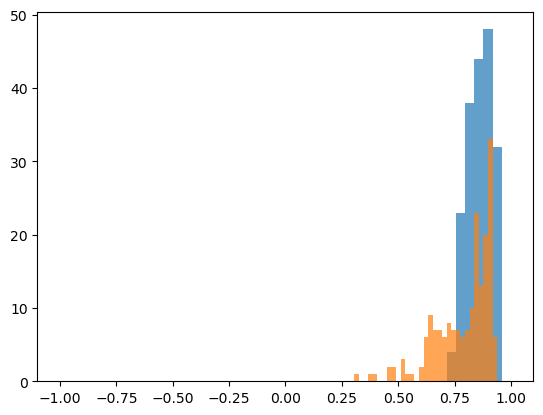

In [132]:
j = 1

distr_hqi_i = np.sort(smx_h[(label_test[:, None] != np.arange(14)[None,:])].reshape(-1,13), 1)[:,-j]
distr_nn_i = np.sort(smx_n[(label_test[:, None] != np.arange(14)[None,:])].reshape(-1,13), 1)[:,-j]

_ = plt.hist(distr_hqi_i, bins=np.linspace(-1,1,50), alpha=.7)
_ = plt.hist(distr_nn_i, bins=np.linspace(0,1,50), alpha=.7)

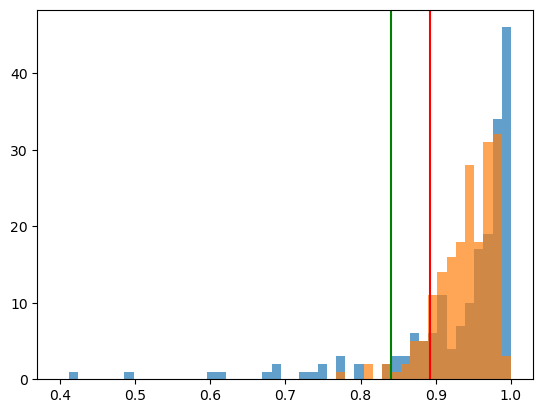

In [158]:
_ = plt.hist(smx_h[np.arange(smx_h.shape[0]), label_test], bins=np.linspace(0.4,1,50), alpha=.7)
_ = plt.hist(smx_n[np.arange(smx_h.shape[0]), label_test], bins=np.linspace(0.4,1,50), alpha=.7)

_ = plt.axvline(x = 1-np.quantile(1-distr_hqi, .9), color = 'g', label = 'axvline - full height')
_ = plt.axvline(x = 1-np.quantile(1-distr_nn, .9), color = 'r', label = 'axvline - full height')

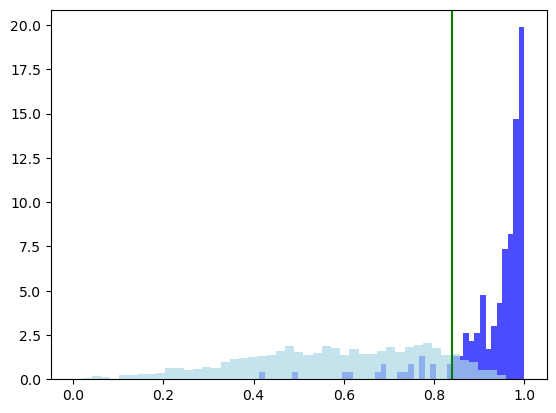

In [232]:
j = 5

#distr_hqi_i = np.sort(smx_h[(label_test[:, None] != np.arange(14)[None,:])].reshape(-1,13), 1)[:,-j]
distr_hqi_i = smx_h[(label_test[:, None] != np.arange(14)[None,:])]
distr_hqi = smx_h[np.arange(smx_h.shape[0]), label_test]

_ = plt.hist(distr_hqi, bins=np.linspace(0.4,1,50), alpha=.7, density=True, color='blue')
_ = plt.hist(distr_hqi_i, bins=np.linspace(0,1,50), alpha=.7, density=True, color='lightblue')
_ = plt.axvline(x = 1-np.quantile(1-distr_hqi, .90), color = 'g', label = 'axvline - full height')
#_ = plt.axvline(x = np.quantile(distr_hqi_i, .95), color = 'r', label = 'axvline - full height')

In [206]:
pd.DataFrame(distr_nn_i).to_csv('distr_nn_i.csv')

In [207]:
pd.DataFrame(distr_hqi_i).to_csv('distr_hqi_i.csv')

In [231]:
1-np.quantile(1-distr_hqi, .90), 1-np.quantile(1-distr_nn, .90)

(0.8409702015102123, 0.8927158197836138)

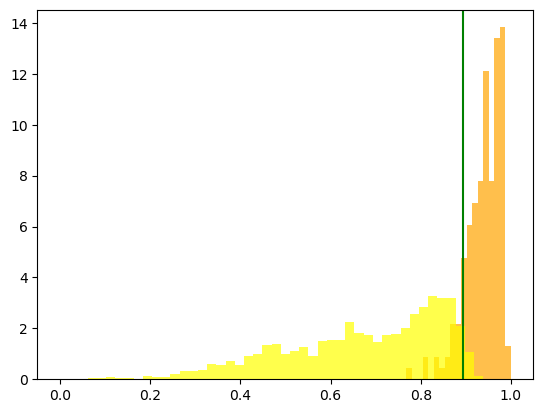

In [233]:
j = 5

#distr_nn_i = np.sort(smx_n[(label_test[:, None] != np.arange(14)[None,:])].reshape(-1,13), 1)[:,-j]
distr_nn_i = smx_n[(label_test[:, None] != np.arange(14)[None,:])]
distr_nn = smx_n[np.arange(smx_h.shape[0]), label_test]

_ = plt.hist(distr_nn, bins=np.linspace(0.4,1,50), alpha=.7, density=True, color='orange')
_ = plt.hist(distr_nn_i, bins=np.linspace(0,1,50), alpha=.7, density=True, color='yellow')
_ = plt.axvline(x = 1-np.quantile(1-distr_nn, .90), color = 'g', label = 'axvline - full height')
#_ = plt.axvline(x = np.quantile(distr_nn_i, .95), color = 'r', label = 'axvline - full height')

In [174]:
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF


In [189]:
ecdf_h = ECDF(distr_hqi)
ecdf_n = ECDF(distr_nn)

In [190]:
1-np.quantile(1-distr_nn, .95)

0.8710339378744555

In [191]:
np.quantile(distr_hqi, .05)

0.748001375718185

In [193]:
ecdf_h(0.748001375718185)

0.05291005291005291

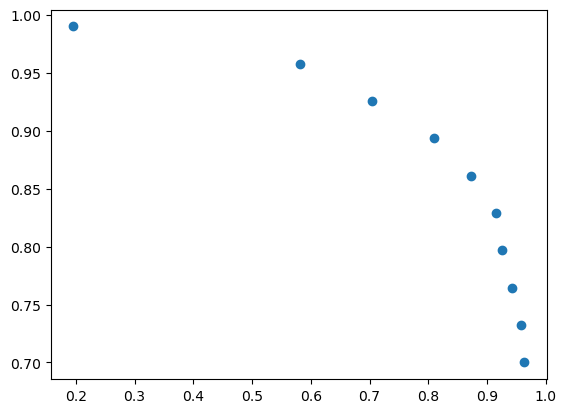

In [243]:
#thrs = np.concatenate([np.linspace(0.6,.8,10), np.linspace(0.8,.9,10)])
thrs = np.linspace(0.7,.99,10)
plt.scatter(1-ecdf_h(thrs), thrs)
#plt.scatter(1-ecdf_n(np.linspace(0.6,.9,10)), np.linspace(0.6,.9,10))

In [228]:
pd.DataFrame({'threshold':thrs, 'coverage':1-ecdf_h(thrs)})

,threshold,coverage
0,0.600000,0.989418
1,0.622222,0.978836
2,0.644444,0.978836
3,0.666667,0.978836
4,0.688889,0.968254
5,0.711111,0.962963
6,0.733333,0.957672
7,0.755556,0.941799
8,0.777778,0.925926
9,0.800000,0.920635


In [271]:
pd.DataFrame({'threshold':np.linspace(0.7,.99,10), 'coverage':1-ecdf_h(np.linspace(0.7,.99,10))})

,threshold,coverage
0,0.700000,0.962963
1,0.732222,0.957672
2,0.764444,0.941799
3,0.796667,0.925926
4,0.828889,0.915344
5,0.861111,0.873016
6,0.893333,0.809524
7,0.925556,0.703704
8,0.957778,0.582011
9,0.990000,0.195767


In [317]:
alphas
#plt.scatter(thrs, 1-ecdf_h(thrs))
#plt.scatter(thrs, res_df_hqi['set_size_mean'])

array([0.        , 0.        , 0.        , 0.        , 0.00529101,
       0.01058201, 0.02116402, 0.05820106, 0.15873016, 0.8042328 ])

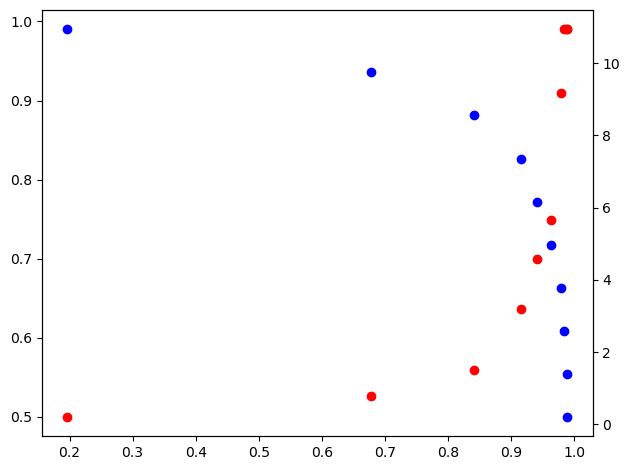

In [320]:
thrs = np.linspace(0.5,.99,10)
alphas = ecdf_h(thrs)
#res_df_hqi, _ = experiment(smx, label_test, alphas, N=500, adaptive=0, cal_prop=0.9, initial_seed=0)

fig, ax1 = plt.subplots()

ax1.scatter(1-ecdf_h(thrs), thrs, c='b')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.scatter(1-ecdf_h(thrs), res_df_hqi['set_size_mean'], c='r')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [275]:
smx = smx_pcc(X_train, X_test, label_train)
res_df_hqi, _ = experiment(smx, label_test, alphas, N=500, adaptive=0, cal_prop=0.9, initial_seed=0)
res_df_hqi

,n_sim,alpha,cov_mean,set_size_mean,cov_sd,set_size_sd,zero_sets,one_sets
0,500,0.037037,0.971684,5.665789,0.040923,0.590290,0.000000,0.000526
1,500,0.042328,0.965474,5.422421,0.044587,0.584626,0.000000,0.002842
2,500,0.058201,0.955368,4.578947,0.048834,0.494882,0.000211,0.016316
3,500,0.074074,0.938211,3.688842,0.058032,0.436354,0.006737,0.045579
4,500,0.084656,0.924947,3.181158,0.062818,0.507306,0.012000,0.111789
5,500,0.126984,0.881789,1.795263,0.078657,0.278669,0.074526,0.385053
6,500,0.190476,0.813474,1.269895,0.091646,0.190462,0.121263,0.554737
7,500,0.296296,0.709579,0.884000,0.114074,0.170305,0.260842,0.601158
8,500,0.417989,0.591368,0.596105,0.120437,0.128314,0.408632,0.586632
9,500,0.804233,0.206632,0.206632,0.098190,0.098190,0.793368,0.206632


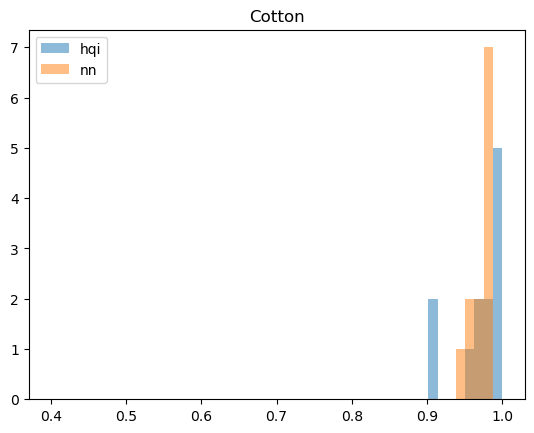

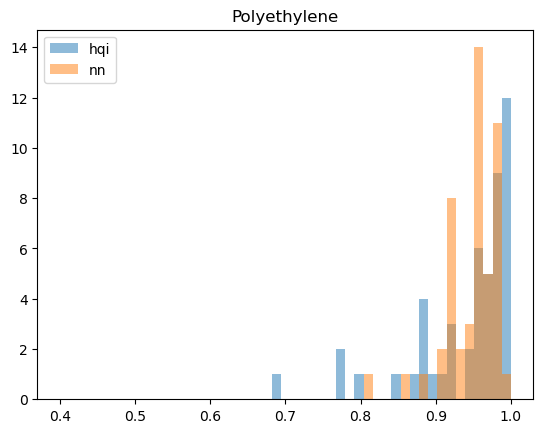

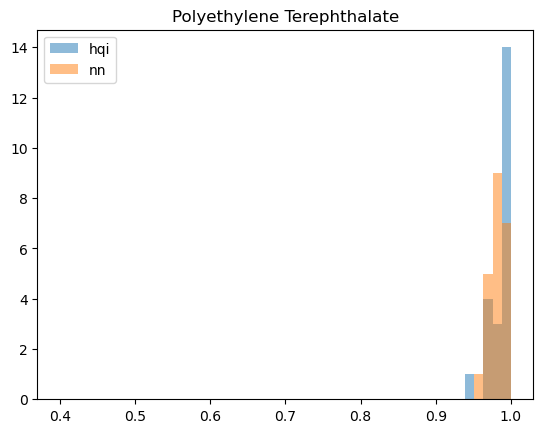

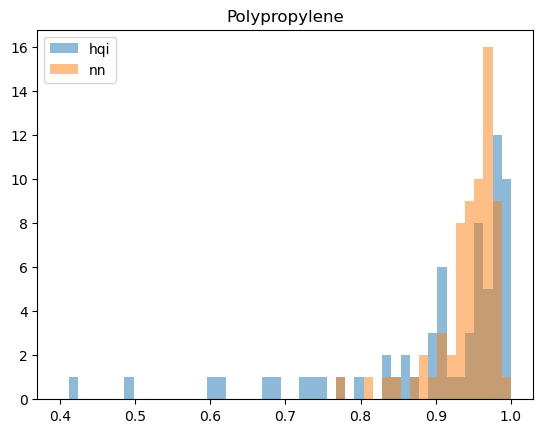

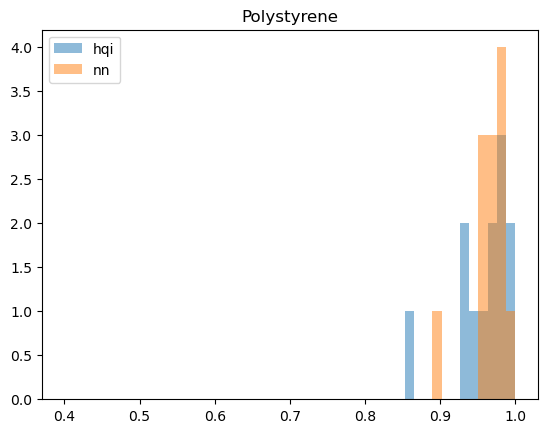

In [109]:
smx_h = smx_pcc(X_train_a, X_test_a, label_train_a)
smx_n = smx_nn(X_train_a, X_test_a, label_train_a)

distr_hqi_list = []
distr_nn_list = []

for i in range(5):
    distr_hqi = smx_h[np.arange(label_test_a.shape[0]),label_test_a][label_test_a==i]
    distr_nn = smx_n[np.arange(label_test_a.shape[0]),label_test_a][label_test_a==i]
    distr_hqi_list.append(distr_hqi)
    distr_nn_list.append(distr_nn)
    plt.hist(distr_hqi, bins=np.linspace(0.4,1,50), alpha=.5, label='hqi')
    plt.hist(distr_nn, bins=np.linspace(0.4,1,50), alpha=.5, label='nn')
    plt.title(label_table_adaptive.iloc[i,1])
    plt.legend()
    plt.show()

In [112]:
label_table_adaptive

,label,polymer
2,0,Cotton
5,1,Polyethylene
6,2,Polyethylene Terephthalate
9,3,Polypropylene
10,4,Polystyrene


In [111]:
distr_hqi_list

[array([0.98491921, 0.99061037, 0.98650346, 0.99265128, 0.90601675,
        0.98950091, 0.97165428, 0.98969682, 0.90550068, 0.99294214,
        0.96894323, 0.9630032 ]),
 array([0.97197809, 0.88173947, 0.89387013, 0.97537084, 0.93934007,
        0.95597621, 0.84099684, 0.91711061, 0.99147291, 0.88216278,
        0.9923053 , 0.99507079, 0.99303791, 0.96646758, 0.99471672,
        0.98173767, 0.99871696, 0.96244206, 0.86927526, 0.99466121,
        0.92333656, 0.96257456, 0.98814049, 0.68766359, 0.97559253,
        0.8841631 , 0.77690595, 0.7744982 , 0.97656808, 0.8878972 ,
        0.9934896 , 0.94189124, 0.98636674, 0.92430722, 0.79971101,
        0.98526432, 0.98451707, 0.98797408, 0.98745315, 0.98817567,
        0.95139953, 0.96172152, 0.96680964, 0.98827069, 0.97314889,
        0.98344067, 0.9542325 , 0.97715173, 0.91293468]),
 array([0.99037082, 0.97538716, 0.97876512, 0.98200543, 0.99648745,
        0.99836658, 0.99044139, 0.99758557, 0.98505135, 0.99529142,
        0.99639311, 0.99

In [113]:
distr_nn_list

[array([0.98012889, 0.98559897, 0.98118833, 0.98597601, 0.93897136,
        0.98484325, 0.96700103, 0.98372152, 0.95327744, 0.98740713,
        0.96515721, 0.9623953 ]),
 array([0.95650682, 0.92897149, 0.92429826, 0.95400604, 0.93960946,
        0.95764706, 0.91784286, 0.940408  , 0.98003263, 0.92051765,
        0.98117286, 0.98096891, 0.97946562, 0.95929849, 0.98170703,
        0.96184267, 0.99089657, 0.95672508, 0.91030454, 0.98236851,
        0.92493055, 0.95277694, 0.9681086 , 0.80755818, 0.95465947,
        0.92341052, 0.8805735 , 0.86503078, 0.96224439, 0.92562154,
        0.98133305, 0.93730005, 0.9758012 , 0.9264632 , 0.91274382,
        0.97607769, 0.97208846, 0.97701204, 0.97364414, 0.97409236,
        0.95313016, 0.9542956 , 0.95370959, 0.97564621, 0.95577492,
        0.96766666, 0.93924176, 0.96063316, 0.92354335]),
 array([0.98280304, 0.966928  , 0.97292833, 0.97673064, 0.99061402,
        0.99378508, 0.98451171, 0.99264769, 0.97749901, 0.98877019,
        0.99030704, 0.98

In [145]:
pd.DataFrame({'alpha':cov_by_set_size_hqi.keys(), 'qhat':1-np.array(qhat_dict['set_size_sd']).mean(1)})

,alpha,qhat
0,0.01,0.432029
1,0.02,0.531803
2,0.03,0.618428
3,0.04,0.690419
4,0.05,0.706856
5,0.10,0.825435
6,0.15,0.866377
7,0.20,0.891141


In [127]:
for alpha in cov_by_set_size_hqi.keys():
    cov_by_set_size_list = []
    for df in [cov_by_set_size_hqi[alpha], cov_by_set_size_hqi2[alpha]]:
        cov_by_label_table = (pd.concat(df).
         groupby('set_size').
         mean()).reset_index()#.
         #merge(label_table, left_index=True, right_on='set_size'))#.
         #merge(pd.concat(set_size_by_label[0.06076923076923077]).groupby('label').count(), left_on='id', right_on='label'))
        #del cov_by_label_table['set_size']
        #cov_by_label_table.columns = ['cov','polymer']
        cov_by_label_table = np.round(cov_by_label_table.set_index('set_size'), 2)#.sort_values('coverage')
        cov_by_set_size_list.append(cov_by_label_table)
    print(1-alpha,
          (cov_by_set_size_list[0].
                   merge(cov_by_set_size_list[1], left_index=True, right_index=True).
                   query('coverage_x>0 and coverage_y>0')).min())

0.99 coverage_x    96.36
coverage_y    76.63
dtype: float64
0.98 coverage_x    95.23
coverage_y    78.33
dtype: float64
0.97 coverage_x    96.40
coverage_y    70.85
dtype: float64
0.96 coverage_x    25.58
coverage_y    79.66
dtype: float64
0.95 coverage_x    84.44
coverage_y    78.01
dtype: float64
0.9 coverage_x    82.76
coverage_y    34.89
dtype: float64
0.85 coverage_x    86.13
coverage_y    65.06
dtype: float64
0.8 coverage_x    92.89
coverage_y    91.11
dtype: float64


In [128]:
set_size_by_label_list = []
for df in [set_size_by_label_hqi[0.05], set_size_by_label_hqi2[0.05]]:
    set_size_by_label_table = (pd.concat(df).
     groupby('label').
     mean().
     merge(label_table, left_index=True, right_on='label'))#.
     #merge(pd.concat(set_size_by_label[0.06076923076923077]).groupby('label').count(), left_on='id', right_on='label'))
    del set_size_by_label_table['label']
    set_size_by_label_table.columns = ['set size','polymer']
    set_size_by_label_table = np.round(set_size_by_label_table.set_index('polymer').sort_values('set size'), 2)
    set_size_by_label_list.append(set_size_by_label_table)

In [222]:
(set_size_by_label_list[0].
 merge(set_size_by_label_list[1], on='polymer').
 merge(set_size_by_label_list[2], on='polymer'))

NameError: name 'set_size_by_label_list' is not defined

In [130]:
(set_size_by_label_list[0].
 merge(set_size_by_label_list[1], on='polymer'))

,set size_x,set size_y
polymer,,
Acrylonitrile Butadiene Styrene,2.00,1.00
Polyamide,2.96,1.62
Polystyrene,3.04,1.60
Polyethylene,3.45,1.88
Cotton,3.90,1.21
Polypropylene,3.98,2.60
Polyethylene Terephthalate,4.01,1.00
Polycarbonate,4.71,1.00
Polyethylene Vinyl Acetate,4.89,5.94


In [377]:
cov_by_label_list = []
alpha = alphas[5]
for df in [cov_by_label_hqi[alpha]]:#, cov_by_label_hqi2[0.05]]:
    cov_by_label_table = (pd.concat(df).
     groupby('label').
     mean().
     merge(label_table, left_index=True, right_on='label'))#.
     #merge(pd.concat(set_size_by_label[0.06076923076923077]).groupby('label').count(), left_on='id', right_on='label'))
    del cov_by_label_table['label']
    cov_by_label_table.columns = ['cov','polymer']
    cov_by_label_table = np.round(cov_by_label_table.set_index('polymer').sort_values('cov'), 2)
    cov_by_label_list.append(cov_by_label_table)

print(1-alpha)
cov_by_label_list[0]  

0.7888888888888889


,cov
polymer,
Polypropylene,81.38
Polyethylene,83.22
Polyethylene Terephthalate,84.97
Cotton,91.07
Polystyrene,92.25


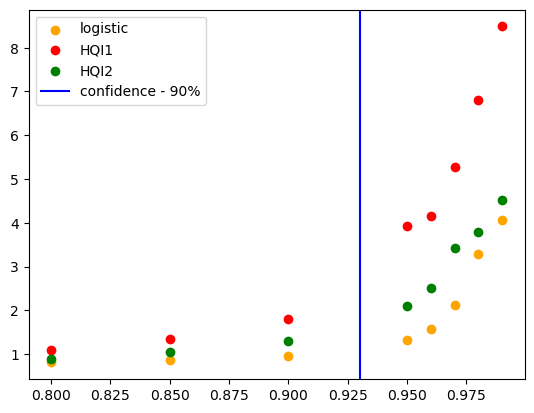

In [502]:
plt.scatter(1-res_df_log['alpha'], res_df_log['set_size_mean'], c='orange', label='logistic')
plt.scatter(1-res_df_hqi['alpha'], res_df_hqi['set_size_mean'], c='red', label='HQI1')
plt.scatter(1-res_df_hqi2['alpha'], res_df_hqi2['set_size_mean'], c='g', label='HQI2')
plt.axvline(x = 0.93, color = 'b', label = 'confidence - 90%')
plt.legend()

In [65]:
res_df_hqi

,alpha,cov_mean,set_size_mean,cov_sd,set_size_sd,zero_sets,one_sets
0,0.01,0.994684,8.507947,0.012488,0.788009,0.000000,0.000000
1,0.02,0.986737,6.792684,0.020620,1.140858,0.000000,0.000632
2,0.03,0.980895,5.312842,0.024389,0.595481,0.000105,0.002158
3,0.04,0.966789,4.176789,0.031638,0.374945,0.001789,0.006579
4,0.05,0.959895,3.889947,0.037155,0.436757,0.003947,0.013316
5,0.10,0.908211,1.840000,0.051634,0.319454,0.033789,0.405895
6,0.15,0.861421,1.359684,0.061599,0.141504,0.089895,0.545158
7,0.20,0.809105,1.106895,0.066060,0.123528,0.131368,0.644947
